In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [19]:
# Add fixed params to dict
params = {}
params['c'] = 0.067
params['s'] = 1
params['sigma'] = 0.272
params['alpha_r'] = 0
params['c_d_max'] = 1
params['a_0'] = 2*np.pi
params['Lambda'] = np.deg2rad(0)
params['alpha_c'] = np.deg2rad(0)

In [20]:
# create configs
configs = []
locked_params = {}
locked_params['m_w'] = 0.884
locked_params['I_xx_w'] = 0.03978611
locked_params['eta_0'] = 0.00047
locked_params['eta_1'] = -0.00238
locked_params['a_1'] = 2*np.pi
configs.append(({'Mode':'Locked'},locked_params))

removed_params = {}
removed_params['m_w'] = 0.735
removed_params['I_xx_w'] = 0.014820479
removed_params['eta_0'] = 0.0020145
removed_params['eta_1'] = -0.002775
removed_params['a_1'] = 0
configs.append(({'Mode':'Removed'},removed_params))

In [21]:
# create Jobs
attitudes=[]
vs = [15,20,25,30]
for v in vs:
    aas = [7,14,21]
    offset = [-0.13,-0.10,0.05]
    for i,tm in enumerate([1.57,2.31,2.75]):
        beta = (tm)*8.4e-4*v**2+offset[i]
        attitudes.append(({"AileronAngle":aas[i],},{"V":v,"beta":beta}))

In [22]:
jobs=[({**config,**att},{**params,**config_params,**att_params}) for config,config_params in configs for att,att_params in attitudes]
jobs[0][1]

{'c': 0.067,
 's': 1,
 'sigma': 0.272,
 'alpha_r': 0,
 'c_d_max': 1,
 'a_0': 6.283185307179586,
 'Lambda': 0.0,
 'alpha_c': 0.0,
 'm_w': 0.884,
 'I_xx_w': 0.03978611,
 'eta_0': 0.00047,
 'eta_1': -0.00238,
 'a_1': 6.283185307179586,
 'V': 15,
 'beta': 0.16673000000000004}

33.650053384925776


{'Mode': 'Locked',
 'AileronAngle': 7,
 'c': 0.067,
 's': 1,
 'sigma': 0.272,
 'alpha_r': 0,
 'c_d_max': 1,
 'a_0': 6.283185307179586,
 'Lambda': 0.0,
 'alpha_c': 0.0,
 'm_w': 0.884,
 'I_xx_w': 0.03978611,
 'eta_0': 0.00047,
 'eta_1': -0.00238,
 'a_1': 6.283185307179586,
 'V': 15,
 'beta': 0.16673000000000004}

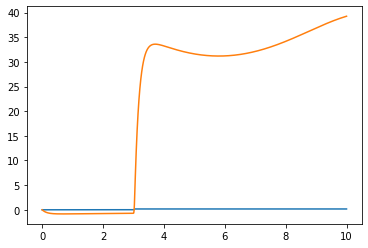

In [23]:
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
#GenRunData('tempModel.py',3,[0]*p.qs*2,10,{**params,**jobs[0]},names,{'Mode':'Free'},100)[100]
data = RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0,0],10,jobs[0][1],names[:2],{**jobs[0][0],**{n:0 for n in names[2:]}},100)
df = pd.DataFrame(data)
plt.plot(df['t'],df['torque'])
plt.plot(df['t'],np.rad2deg(df['Roll Rate']))

print(np.rad2deg(df[df['t']>4]['Roll Rate'].mean()))
{**jobs[0][0],**jobs[0][1]}

In [24]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']

res=[]
for job in jobs:
    res.append(pool.apply_async(RollRig.GenRunData_StepTorque, args = ('RollRigModel-Fixed.py',1,[0]*2,10,job[1],names[:2],{**job[0],**{n:0 for n in names[2:]}},100)))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 324 ms, sys: 104 ms, total: 428 ms
Wall time: 7.01 s


In [25]:
df['Roll Rate [Deg]']=np.rad2deg(df['Roll Rate'])
df[df['t']>4].groupby(['Mode','V','AileronAngle'])['Roll Rate [Deg]'].mean()

Mode     V   AileronAngle
Locked   15  7                33.650053
             14               71.200759
             21              121.750759
         20  7                63.520156
             14              108.710608
             21              156.558180
         25  7                88.939774
             14              142.874819
             21              191.772259
         30  7               113.164140
             14              176.122210
             21              227.762292
Removed  15  7                74.163654
             14              155.630924
             21              262.378719
         20  7               137.059207
             14              233.246115
             21              335.519361
         25  7               191.961403
             14              307.324244
             21              412.040841
         30  7               243.369472
             14              378.617746
             21              489.384030
Name: Roll Rat

In [26]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparison/FixedData.csv', index = False)